# 任务描述
编写一个图像分类系统，能够对输入图像进行类别预测。具体的说，利用数据库的2250张训练样本进行训练；对测试集中的2235张样本进行预测。
## 一、图像处理模块
### 1.提取SIFT特征

In [1]:
import os
import cv2
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from argparse import Namespace 
class ImageProcess():
    """储存图像的相关信息image,label,并对图像做SIFT特征提取

    图像必须是灰度图

    Attributes: 
        image: 灰度图
        label: 图片的种类标签
        keypoints: 图片的所有特征点
        descriptors 图片的每个特征点所对应的向量 [len(keypoints),128]
    """
    def __init__(self, image: np.ndarray ,label: int) -> None:
        """初始化
        """
        if len(image.shape) == 3:    
            self.image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            self.image = image
        self.label=label
    def SIFT(self):
        '''提取图片的SIFT特征点,并对特征点向量归一化
        '''
        #Here kp will be a list of keypoints and des is a numpy array of shape [number of kp, 128]
        keypoints, descriptors = cv2.SIFT_create().detectAndCompute(self.image,None)
        norm = np.linalg.norm(descriptors,axis=1)
        # print(norm.shape) >>(257,)
        norm=norm[:,np.newaxis]
        descriptors /= norm
        self.keypoints=keypoints
        self.descriptors=descriptors

    def draw(self):
        '''绘制特征点
        '''
        img=cv2.drawKeypoints(self.image,self.keypoints,self.image,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        # cv2.imwrite('sift_keypoints.jpg',img)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # 使用 matplotlib 显示图像
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()


### 2.加载数据集，并提取出SIFT特征点

In [2]:
def load_data(config) -> list:
    """加载数据
    
    划分训练集和测试集,计算每个集合中图片的特征。
    保存训练集的特征向量，用于生成词袋。
    """
    train_image=[]
    test_image=[]
    feature_set = np.float32([]).reshape(0, 128)
    print("---计算每张图片的SIFT特征点---")
    for root,dir,files in os.walk(config.image_dir):
        if files:
            #文件名称按照"1.jpg""2.jpg"排序，原读取顺序为"1.jpg""10.jpg"
            files=sorted(files,key=lambda x:int(x.split('.')[0]))
            label=int(root.split('\\')[-1])
            for i,file in enumerate(files):
                path=os.path.join(root,file)
                # print(path)
                image=cv2.imread(path,0)
                extractor=ImageProcess(image,label)
                extractor.SIFT()
                if i<150:
                    train_image.append(extractor)
                    if not os.path.exists(os.path.join(config.data_dir,'feature_set.npy')):
                        feature_set = np.vstack([feature_set, extractor.descriptors]) 
                else:
                    test_image.append(extractor)
    if not os.path.exists(os.path.join(config.data_dir,'feature_set.npy')):
        np.save(os.path.join(config.data_dir,'feature_set.npy'),feature_set)
    # print(len(feature_set))
    return train_image,test_image    #[ImageProcess]

### 3.特征点聚类，生成词袋

In [3]:
class Bow():
    """将n类特征点的中心点作为视觉词汇,生成词袋

    Attributes:
        numOfBag: 词袋大小
        feature_set: 特征点集合
    """
    def __init__(self, feature_set, numOfBag) -> None:
        """初始化
        """
        self.numOfBag=numOfBag
        self.feature_set=feature_set
    def generateBoW(self,config) -> np.ndarray:
        """生成词袋，并保存到默认路径
        """
        print("---生成词袋---")
        np.random.shuffle(self.feature_set)
        kmeans = MiniBatchKMeans(n_clusters=self.numOfBag, random_state=42).fit(self.feature_set)
        centers = kmeans.cluster_centers_
        np.save(os.path.join(config.data_dir,f"Bow_{self.numOfBag}.npy"), centers)
        return centers
    def getBow(self,config):
        """读取指定路径的词袋模型文件
        """
        print("---加载已有的词袋文件---")
        centers = np.load(os.path.join(config.data_dir,f'Bow_{self.numOfBag}.npy'))
        self.vocabulary = centers
        return centers

### 4.SPM算法对数据集进一步处理，得到最后模型训练需要的数据集

In [4]:
class SPM():
    """ 使用SPM算法,生成图片的特征向量,构建数据集

    Attributes:
        image_set: 图片信息的集合。
        centers: 聚类中心也就是词汇表。
    """
    def __init__(self,image_set,centers) -> None:
        self.image_set=image_set
        self.centers=centers
        self.numOfBag=len(self.centers)
    def single_compute_histogram(self, features, keypoints, image):
        '''统计不同尺度下图像的特征直方图,并合并
        '''
        histogram_16 = np.zeros((16, self.numOfBag))
        histogram_4 = np.zeros((4, self.numOfBag))
        histogram_1 = np.zeros((1, self.numOfBag))
        #len() 函数计算一个二维数组（或任何序列的序列，例如列表的列表）时，它返回的是最外层序列的长度，也就是二维数组的行数
        #len(features)=len(keypoints)
        for i in range(len(keypoints)):
            feature = features[i]
            keypoint = keypoints[i]
            x, y = keypoint.pt
            block_id = int(4 * x//image.shape[1] + (4 * y//image.shape[0]) * 4)
            #维度问题会广播
            #这里的feature是一行特征点向量，判断每一个特征点向量距离哪个视觉词汇最近
            dis=np.sum((feature-self.centers)**2,axis=1)
            index=np.argmin(dis)
            #第二维是词汇表的大小，numofbag
            histogram_16[block_id][index]+=1
        histogram_4[0] = histogram_16[0] + histogram_16[1] + histogram_16[4] + histogram_16[5]
        histogram_4[1] = histogram_16[2] + histogram_16[3] + histogram_16[6] + histogram_16[7]
        histogram_4[2] = histogram_16[8] + histogram_16[9] + histogram_16[12] + histogram_16[13]
        histogram_4[3] = histogram_16[10] + histogram_16[11] + histogram_16[14] + histogram_16[15]
        for i in range(4):
            histogram_1[0] += histogram_4[i]
        #将不同尺度下的特征图合并 (1+4+16)*numOfBag,这是一张图片的特征向量表示
        C1, C2, C3=0.25, 0.25, 0.5
        result = np.float32([]).reshape(0, self.numOfBag)
        result = np.append(result, histogram_1 * C1, axis=0)
        result = np.append(result, histogram_4 * C2, axis=0)
        result = np.append(result, histogram_16 * C3, axis=0)
        return result
    
    def generate_dataset(self):
        """生成图片特征向量数据集
        """
        #len(self.centers)==numOfBag
        #特征向量shape为[21,numOfBag],将其展开存，每行存一张图片的特征
        print('---生成数据集的特征向量---')
        dataset=np.float32([]).reshape(0,self.numOfBag*21)
        labels=[]
        for item in self.image_set:
            labels.append(item.label)
            vec=self.single_compute_histogram(item.descriptors, item.keypoints, item.image)
            #flatten会有不必要的复制。ravel后只是一维向量，还有reshape成二维
            vec=vec.ravel().reshape(-1,21*self.numOfBag)
            dataset=np.append(dataset,vec,axis=0)
        return dataset,labels


## 图片分类模块
### 模型训练与结果预测评估

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
def train(dataset,labels,config):
    print("---模型训练---")
    svc=SVC(kernel=config.kernel, C=config.C, gamma=config.gamma, decision_function_shape='ovo')
    svc.fit(dataset,labels)
    return svc
def single_predict(data,model):
    """预测单独一张图片的结果
    """
    data=data.reshape(1,-1)
    prediction = model.predict(data)
    return prediction
def predict(dataset,model):
    """预测数据集的结果
    """
    prediction = model.predict(dataset)
    return prediction
def evaluate(true_labels, prediction, target_names):
    '''评估模型预测结果,生成分类报告和混淆矩阵
    '''
    report = metrics.classification_report(true_labels, prediction, target_names=target_names)
    confuse_matrix = confusion_matrix(true_labels, prediction)
    return report, confuse_matrix
def plot_matrix(cm,classes,path):
    """可视化混淆矩阵
    """
    #转成浮点数
    cm=cm.astype(np.float32)
    #计算每个真实类别的样本数
    s=np.sum(cm,axis=1).astype(np.float32)  #[15,]
    s=s.reshape(-1,1)
    cm=cm/s*100
    fig=plt.figure()
    sub = fig.add_subplot(111)
    color = sub.matshow(cm)
    fig.colorbar(color)
    for i in range(len(cm)):
        sub.text(i,i,format(cm[i][i],'.2f'),va='center',ha='center',fontsize=6)
    sub.set_xticks(range(len(classes)))
    sub.set_yticks(range(len(classes)))
    sub.set_xticklabels(classes, rotation=90)
    sub.set_yticklabels(classes)
    sub.set_xlabel('Predicted labels')
    sub.set_ylabel('True labels')
    plt.savefig(path)
    plt.show()
   

## 主函数模块

Notice：运行程序之前，请先配置好config。
1. 确认相关路径的正确性。
2. 设置超参数值
3. 根据data目录中是否存好了数据判断True or False

In [6]:
config=Namespace(
    image_dir="15-Scene",
    data_dir="data",
    numOfBag=300,
    C=10,
    gamma=0.001,
    kernel='linear',
    categories=['Bedroom','Suburb','Industrial','Kitchen','Living room','Coast','Forest','Highway'
                ,'Inside city','Mountain','Open country','Street','Tall Building','Office','Store'],
    sign=True~ #判断是否需要处理数据集
)

if not os.path.exists(config.data_dir):
    os.mkdir(config.data_dir)

#如果数据集需要处理或者没有feature_set.npy文件，需要重新计算
#多加的判断是防止数据集处理过了，但是feature_set文件丢失
if config.sign or not os.path.exists(os.path.join(config.data_dir,'feature_set.npy')):
    train_image,test_image=load_data(config)
    print(len(train_image))
    print(len(test_image))
feature_set=np.load(os.path.join(config.data_dir,'feature_set.npy'))
vocab=Bow(feature_set, config.numOfBag)
if os.path.exists(os.path.join(config.data_dir,f'Bow_{vocab.numOfBag}.npy')):
    centers=vocab.getBow(config)
else:
    centers=vocab.generateBoW(config)
if config.sign:  
    train_spm=SPM(train_image,centers)
    test_spm=SPM(test_image,centers)
    train_set,train_labels=train_spm.generate_dataset()
    test_set,test_labels=test_spm.generate_dataset()
    np.save(os.path.join(config.data_dir,f"train_set_{vocab.numOfBag}.npy"), train_set)
    np.save(os.path.join(config.data_dir,f"train_labels_{vocab.numOfBag}.npy"), train_labels)
    np.save(os.path.join(config.data_dir,f"test_set_{vocab.numOfBag}.npy"), test_set)
    np.save(os.path.join(config.data_dir,f"test_labels_{vocab.numOfBag}.npy"), test_labels)
else:
    print('---直接加载数据集的特征向量---')  
    train_set = np.load(os.path.join(config.data_dir,f"train_set_{vocab.numOfBag}.npy"))
    train_labels = np.load(os.path.join(config.data_dir,f"train_labels_{vocab.numOfBag}.npy"))
    test_set = np.load(os.path.join(config.data_dir,f"test_set_{vocab.numOfBag}.npy"))
    test_labels = np.load(os.path.join(config.data_dir,f"test_labels_{vocab.numOfBag}.npy"))
print("---开始训练---")
model=train(train_set,train_labels,config)
train_result=predict(train_set,model)
test_result=predict(test_set,model)
train_report, _ = evaluate(train_labels,train_result, config.categories)
test_report, cm = evaluate(test_labels,test_result, config.categories)

---加载已有的词袋文件---
---直接加载数据集的特征向量---
---开始训练---
---模型训练---


In [7]:
print("训练集分类结果：")
print(train_report)

训练集分类结果：
               precision    recall  f1-score   support

      Bedroom       1.00      1.00      1.00       150
       Suburb       1.00      1.00      1.00       150
   Industrial       1.00      1.00      1.00       150
      Kitchen       1.00      1.00      1.00       150
  Living room       1.00      1.00      1.00       150
        Coast       1.00      1.00      1.00       150
       Forest       1.00      1.00      1.00       150
      Highway       1.00      1.00      1.00       150
  Inside city       1.00      1.00      1.00       150
     Mountain       1.00      1.00      1.00       150
 Open country       1.00      1.00      1.00       150
       Street       1.00      1.00      1.00       150
Tall Building       1.00      1.00      1.00       150
       Office       1.00      1.00      1.00       150
        Store       1.00      1.00      1.00       150

     accuracy                           1.00      2250
    macro avg       1.00      1.00      1.00      2250

In [8]:
print("测试集分类结果：")
print(test_report)

测试集分类结果：
               precision    recall  f1-score   support

      Bedroom       0.29      0.48      0.36        66
       Suburb       0.80      0.90      0.85        91
   Industrial       0.46      0.39      0.42       161
      Kitchen       0.30      0.47      0.37        60
  Living room       0.57      0.50      0.53       139
        Coast       0.60      0.80      0.69       210
       Forest       0.82      0.92      0.87       178
      Highway       0.63      0.63      0.63       110
  Inside city       0.66      0.54      0.59       158
     Mountain       0.66      0.71      0.69       224
 Open country       0.63      0.45      0.52       260
       Street       0.63      0.77      0.69       142
Tall Building       0.83      0.56      0.67       206
       Office       0.58      0.45      0.50        65
        Store       0.66      0.66      0.66       165

     accuracy                           0.63      2235
    macro avg       0.61      0.61      0.60      2235

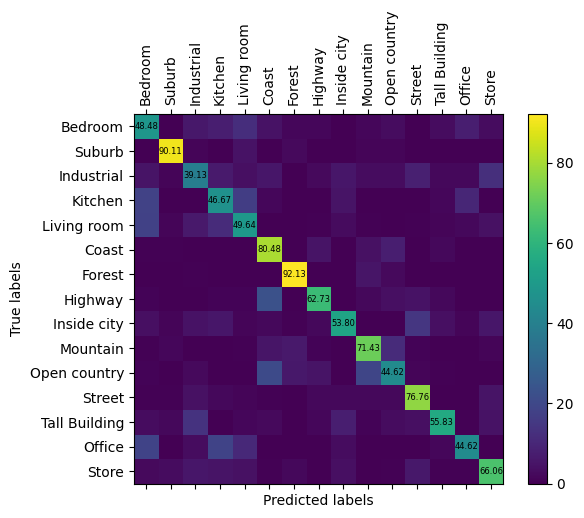

In [9]:
plot_matrix(cm,config.categories,'linear.png')

In [10]:
x=train_set[0]
print(len(x))
print(list(x).count(0))

6300
5728
